<a href="https://colab.research.google.com/github/Shashwot90/objectdetection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2, L1

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteK67WOR/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# @title dataset

dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpahd0dp2ztfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [ ]:
# TRAIN_RATIO = 0.6
# VAL_RATIO = 0.2
# TEST_RATIO = 0.2

# dataset = tf.data.Dataset.range(10)
# print(list(dataset.as_numpy_iterator()))
# DATASET_SIZE = len(dataset)

# train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
# print(list(train_dataset.as_numpy_iterator()))

# val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
# val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
# print(list(val_dataset.as_numpy_iterator()))

# test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
# print(list(val_dataset.as_numpy_iterator()))
# print(list(test_dataset.as_numpy_iterator()))
# dataset = dataset.skip(7)
# list(dataset.as_numpy_iterator())

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))


  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))


  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))


[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [ ]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

###Dataset Visualization

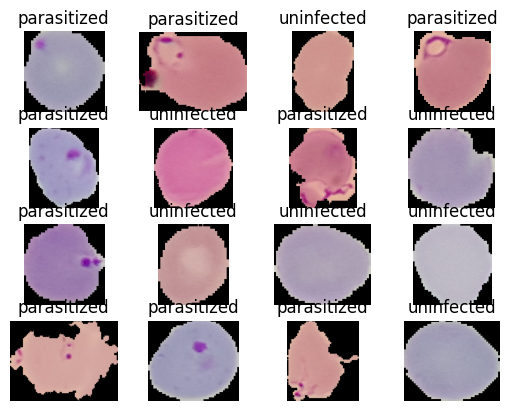

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
# for i, (image, label) in enumerate(train_dataset.take(2)):
#   plt.subplot(1, 4, 2*i + 1)
#   plt.imshow(image)

#   plt.subplot(1, 4, 2*i + 2)
#   plt.imshow(tf.image.adjust_saturation(image, 0.3))

#   plt.title(dataset_info.features['label'].int2str(label))
#   plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(1)

'uninfected'

###Data Preprocessing

###**Data Augmentation**

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.random_saturation(original_image, lower=2, upper=12)

TypeError: ignored

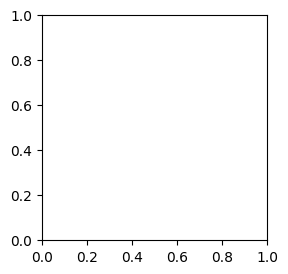

In [ ]:
visualize(original_image, augmented_image)

###Data Processing

In [ ]:
IM_SIZE = 224

original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255)
])

In [ ]:
#tf image
@tf.function
def augment(image, label):

  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [ ]:
#tf layers
augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal',)
])

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

###Data Loading

In [ ]:
# train_dataset = train_dataset.map(augment)
# val_dataset = val_dataset.map(resize_rescale)
############test_dataset = test_dataset.map(resize_rescale_layers)

#train_dataset

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)


tf.Tensor(
[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]], shape=(1, 115, 115, 3), dtype=uint8) tf.Tensor([0], shape=(1,), dtype=int64)


In [ ]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    ####.map(augment_layer)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset = (
    val_dataset
    #.shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    #.prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

###Mixup Data Augmentation

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  #label = lamda*label_1 + (1-lamda)*label_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label


In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    #.map(mixup)
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

###CutMix Data Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

tf.Tensor(
[0.7760682  0.98652744 0.         1.         1.         1.
 1.         0.13075972 0.9999801  0.         0.9999801  1.
 1.         0.         0.         0.         1.         1.
 0.         1.         0.         1.         0.1243822  0.
 1.         0.15084898 0.998007   1.         0.7632135  1.
 1.         0.25      ], shape=(32,), dtype=float32)


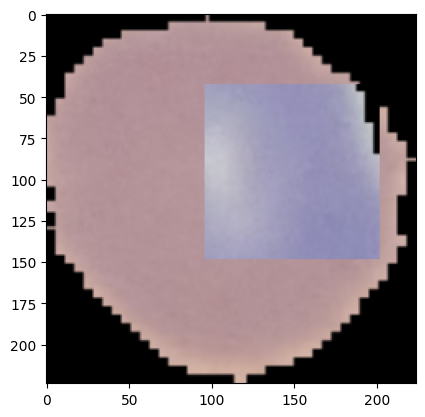

In [ ]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

###Albumentations

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

In [ ]:
plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])


###Model Creation

**Sequential**

In [ ]:
IM_SIZE = 224
dropout_rate = 0.3
regularization_rate = 0.01
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),

    resize_rescale_layers,
    augment_layers,

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation = "relu", kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = "relu", kernel_regularizer = L2(regularization_rate)),
    BatchNormalization(),

    Dense(1, activation="sigmoid"),
])
lenet_model.summary()



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_21 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_29 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 111, 111, 6)     

**Functional API**

In [ ]:
func_input = Input(shape = (IM_SIZE,IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Flatten()(x)
x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      

In [ ]:
func_input = Input(shape = (IM_SIZE,IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)


feature_extractor_model_func = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model_func.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [ ]:
func_input = Input(shape = (IM_SIZE,IM_SIZE, 3), name = "Input Image")

x = feature_extractor_model(func_input)
x = Flatten()(x)
x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

NameError: ignored

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),


])
feature_extractor_seq_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_10 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_11 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

###Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides=2*strides)

  def call(self, x, training):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (IM_SIZE,IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)
x = Flatten()(x)
x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_14 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)


    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_18 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_19 (Ba  multiple                  

In [ ]:
y_true = [0,1,0,0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

###Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w  = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b  = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),
    NeuralearnDense(10, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(1, activation="sigmoid"),
])
lenet_custom_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_20 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_21 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

###CAllbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {}".format(batch+1, logs))

###CSV Logger

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

###Early Stopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

###Learning Rate Sheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

###Model Checkpointing

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'checkpopints/', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq=3,
)

###ReduceLearningRateOnPlateau

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=2, verbose=1
)

###Model Training

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

###Tensorboard

In [ ]:
#rm -rf ./logs/
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer= tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = './logs'+ CURRENT_TIME
print(LOG_DIR)
tensorboard_callback = tf.keras.callbackss.TensorBoard(log_dir=LOG_DIR)

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 3:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

###Custom Metric Class

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'Custom_Accuracy', FACTOR=1):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred)*FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype= tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)


###Custom Metric Method (without parameters)

In [ ]:
def custom_accuracy(y_true, y_pred):
  return binary_accuracy(y_true, y_pred)

###Custom Metric Method (with parameters)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)*FACTOR
  return metric

###Custom Loss Class

In [ ]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

###Custom Loss Method (with parameters)

In [ ]:
FACTOR = 1
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * FACTOR
  return loss

###Custom Loss Method (without parameters)

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = CustomBCE(FACTOR),
              metrics =  CustomAccuracy())

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = CustomBCE(FACTOR),
              metrics = custom_accuracy)

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = CustomBCE(FACTOR),
              metrics = custom_accuracy(FACTOR))

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = custom_bce(FACTOR),
              metrics = metrics)

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = metrics)

###Training

In [ ]:
history = lenet_model.fit(train_dataset,validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
194/689 [=======>......................] - ETA: 48s - loss: 6.7245 - tp: 2467.0000 - fp: 524.0000 - tn: 1031.0000 - fn: 2186.0000 - accuracy: 0.3276 - precision: 0.8248 - recall: 0.5302 - auc: 0.6285

KeyboardInterrupt: ignored

**Hyperparameter Tuning with WandB**

In [ ]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {

    "IM_SIZE": {
        "value" : 224,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [16, 32, 64, 128]
    },

    "N_DENSE_2" : {
      "values" : [16, 32, 64, 128]
    },

    "DROPOUT_RATE":{
      "min": 0.1,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 1,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
def train():
    with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
        config = wandb.config
        model = model_tune(config)
        model.compile(
              optimizer= Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(val_dataset, epochs=2, callbacks = [WandbCallback()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

**Custom Training Loop**

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)

    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)

    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)

    METRIC_VAL.reset_states()
  print("Training Complete!!!!")

In [ ]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

**Visualization**

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=logs

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

tensorboard

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 5, verbose = 1, callbacks = [tensorboard_callback, scheduler_callback])

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 5, verbose = 1, callbacks = [plateau_callback])

Epoch 1/5
689/689 [==============================] - 60s 82ms/step - loss: 0.5947 - tp: 6890.0000 - fp: 2867.0000 - tn: 8154.0000 - fn: 4135.0000 - accuracy: 0.6824 - precision: 0.7062 - recall: 0.6249 - auc: 0.7449 - val_loss: 0.8703 - val_tp: 716.0000 - val_fp: 430.0000 - val_tn: 933.0000 - val_fn: 676.0000 - val_accuracy: 0.5985 - val_precision: 0.6248 - val_recall: 0.5144 - val_auc: 0.6280 - lr: 0.0100
Epoch 2/5
689/689 [==============================] - 43s 62ms/step - loss: 0.5784 - tp: 7173.0000 - fp: 2797.0000 - tn: 8224.0000 - fn: 3852.0000 - accuracy: 0.6984 - precision: 0.7195 - recall: 0.6506 - auc: 0.7646 - val_loss: 0.7001 - val_tp: 673.0000 - val_fp: 371.0000 - val_tn: 994.0000 - val_fn: 717.0000 - val_accuracy: 0.6051 - val_precision: 0.6446 - val_recall: 0.4842 - val_auc: 0.6432 - lr: 0.0100
Epoch 3/5
689/689 [==============================] - 44s 63ms/step - loss: 0.5493 - tp: 7559.0000 - fp: 2648.0000 - tn: 8375.0000 - fn: 3464.0000 - accuracy: 0.7228 - precision: 0.

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 10, verbose = 1, callbacks = [checkpoint_callback])

Epoch 1/10
689/689 [==============================] - 576s 814ms/step - loss: 0.4008 - tp: 8872.0000 - fp: 2046.0000 - tn: 8974.0000 - fn: 2154.0000 - accuracy: 0.8095 - precision: 0.8126 - recall: 0.8046 - auc: 0.8986 - val_loss: 0.3811 - val_tp: 1343.0000 - val_fp: 323.0000 - val_tn: 1047.0000 - val_fn: 42.0000 - val_accuracy: 0.8675 - val_precision: 0.8061 - val_recall: 0.9697 - val_auc: 0.9549
Epoch 2/10
689/689 [==============================] - 503s 728ms/step - loss: 0.4069 - tp: 8812.0000 - fp: 2615.0000 - tn: 8406.0000 - fn: 2213.0000 - accuracy: 0.7810 - precision: 0.7712 - recall: 0.7993 - auc: 0.8860 - val_loss: 0.7072 - val_tp: 66.0000 - val_fp: 8.0000 - val_tn: 1355.0000 - val_fn: 1326.0000 - val_accuracy: 0.5158 - val_precision: 0.8919 - val_recall: 0.0474 - val_auc: 0.6286
Epoch 3/10
689/689 [==============================] - 501s 728ms/step - loss: 0.6623 - tp: 6129.0000 - fp: 3864.0000 - tn: 7156.0000 - fn: 4897.0000 - accuracy: 0.6026 - precision: 0.6133 - recall: 0.

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 10, verbose = 1, callbacks = [scheduler_callback])

NameError: ignored

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 10, verbose = 1, callbacks = [csv_callback, es_callback])

Epoch 1/10
689/689 [==============================] - 74s 84ms/step - loss: 0.3217 - tp: 9710.0000 - fp: 1658.0000 - tn: 9362.0000 - fn: 1316.0000 - accuracy: 0.8651 - precision: 0.8542 - recall: 0.8806 - auc: 0.9354 - val_loss: 0.3269 - val_tp: 1374.0000 - val_fp: 210.0000 - val_tn: 1152.0000 - val_fn: 19.0000 - val_accuracy: 0.9169 - val_precision: 0.8674 - val_recall: 0.9864 - val_auc: 0.9350
Epoch 2/10
689/689 [==============================] - 56s 82ms/step - loss: 0.2131 - tp: 10371.0000 - fp: 944.0000 - tn: 10080.0000 - fn: 651.0000 - accuracy: 0.9277 - precision: 0.9166 - recall: 0.9409 - auc: 0.9660 - val_loss: 0.6927 - val_tp: 1369.0000 - val_fp: 371.0000 - val_tn: 993.0000 - val_fn: 22.0000 - val_accuracy: 0.8574 - val_precision: 0.7868 - val_recall: 0.9842 - val_auc: 0.9293
Epoch 3/10
689/689 [==============================] - 51s 75ms/step - loss: 0.1876 - tp: 10418.0000 - fp: 812.0000 - tn: 10209.0000 - fn: 607.0000 - accuracy: 0.9356 - precision: 0.9277 - recall: 0.9449 

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 52s 75ms/step - loss: 0.0514 - accuracy: 0.9812 - val_loss: 0.3182 - val_accuracy: 0.9227
Epoch 2/20
689/689 [==============================] - 47s 68ms/step - loss: 0.0503 - accuracy: 0.9830 - val_loss: 0.5380 - val_accuracy: 0.9256
Epoch 3/20
689/689 [==============================] - 52s 75ms/step - loss: 0.1310 - accuracy: 0.9510 - val_loss: 2.6171 - val_accuracy: 0.6113
Epoch 4/20
689/689 [==============================] - 49s 70ms/step - loss: 0.2435 - accuracy: 0.9133 - val_loss: 0.3377 - val_accuracy: 0.8940
Epoch 5/20
689/689 [==============================] - 48s 70ms/step - loss: 0.1792 - accuracy: 0.9377 - val_loss: 0.1830 - val_accuracy: 0.9452
Epoch 6/20
689/689 [==============================] - 44s 63ms/step - loss: 0.1403 - accuracy: 0.9484 - val_loss: 0.1994 - val_accuracy: 0.9448
Epoch 7/20
689/689 [==============================] - 54s 79ms/step - loss: 0.1123 - accuracy: 0.9585 - val_loss: 0.2273 - val_accuracy:

In [ ]:
lenet_model_func.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = lenet_model_func.fit(train_dataset,validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 58s 63ms/step - loss: 0.3906 - accuracy: 0.8187 - val_loss: 0.2743 - val_accuracy: 0.9165
Epoch 2/20
689/689 [==============================] - 47s 68ms/step - loss: 0.1955 - accuracy: 0.9356 - val_loss: 0.1929 - val_accuracy: 0.9441
Epoch 3/20
689/689 [==============================] - 50s 73ms/step - loss: 0.1763 - accuracy: 0.9405 - val_loss: 0.1854 - val_accuracy: 0.9405
Epoch 4/20
689/689 [==============================] - 43s 63ms/step - loss: 0.1803 - accuracy: 0.9395 - val_loss: 0.5332 - val_accuracy: 0.9114
Epoch 5/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1573 - accuracy: 0.9482 - val_loss: 0.4321 - val_accuracy: 0.7564
Epoch 6/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1584 - accuracy: 0.9469 - val_loss: 0.1887 - val_accuracy: 0.9390
Epoch 7/20
689/689 [==============================] - 53s 77ms/step - loss: 0.1357 - accuracy: 0.9527 - val_loss: 2.3187 - val_accuracy:

In [ ]:
lenet_sub_classed.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = lenet_sub_classed.fit(train_dataset,validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 [==============================] - 53s 67ms/step - loss: 0.3839 - accuracy: 0.8233 - val_loss: 0.3934 - val_accuracy: 0.8813
Epoch 2/5
689/689 [==============================] - 47s 68ms/step - loss: 0.2090 - accuracy: 0.9288 - val_loss: 0.1925 - val_accuracy: 0.9379
Epoch 3/5
689/689 [==============================] - 45s 65ms/step - loss: 0.1878 - accuracy: 0.9383 - val_loss: 0.3253 - val_accuracy: 0.8998
Epoch 4/5
689/689 [==============================] - 54s 78ms/step - loss: 0.1679 - accuracy: 0.9438 - val_loss: 0.1663 - val_accuracy: 0.9452
Epoch 5/5
689/689 [==============================] - 54s 78ms/step - loss: 0.1507 - accuracy: 0.9489 - val_loss: 0.1962 - val_accuracy: 0.9321


In [ ]:
lenet_custom_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = lenet_custom_model.fit(train_dataset,validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 [==============================] - 52s 69ms/step - loss: 0.2909 - accuracy: 0.8836 - val_loss: 0.3281 - val_accuracy: 0.8980
Epoch 2/5
689/689 [==============================] - 44s 63ms/step - loss: 0.2511 - accuracy: 0.9105 - val_loss: 4.5702 - val_accuracy: 0.4962
Epoch 3/5
689/689 [==============================] - 52s 75ms/step - loss: 0.4052 - accuracy: 0.8208 - val_loss: 2272.5217 - val_accuracy: 0.5140
Epoch 4/5
689/689 [==============================] - 44s 64ms/step - loss: 0.3232 - accuracy: 0.8884 - val_loss: 32.1912 - val_accuracy: 0.5045
Epoch 5/5
689/689 [==============================] - 45s 66ms/step - loss: 0.2560 - accuracy: 0.9109 - val_loss: 2.6337 - val_accuracy: 0.8733


In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL= BinaryAccuracy()
EPOCHS=3

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
    y_pred = lenet_model(x_batch, training = True)
    loss = custom_bce(y_batch, y_pred)

  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
  y_pred_val = model(x_batch_val, training = False)
  loss_val = custom_bce(y_batch_val, y_pred_val)
  METRIC_VAL.update_state(y_batch_val, y_pred_val)
  return loss_val

In [ ]:
for epoch in range(EPOCHS):
  print("Training starts for epoch number {}", format(epoch+1))
  for (x_batch_val, y_batch_val) in val_dataset:
    loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss is:", loss_val)
    print("The Validation accuracy is", METRIC_VAL.result())
    METRIC_VAL.reset_states()



In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, train_dataset, val_dataset, EPOCHS):
  for epoch in EPOCHS:
    print("Training starts for epoch number {}", format(epoch+1))
    for (x_batch, y_batch) in train_dataset:
      with tf.GradientTape as recorder:
        y_pred = model(x_batch, training = True)
        loss = custom_bce(y_batch, y_pred)

        partial_derivatives = recorder.gradient(loss, ,model.trainable_weights)
        OPTIMIZER.apply_gradient(zip(partial_derivatives, model.trainable_weights))

        METRIC.update_state(y_batch, y_pred)

        if(step%300 == 0):
          print("Training loss", loss)
        print("The accuracy is:", METRIC.result())
        METRIC.reset_states()
        for (x_batch_val, y_batch_val) in val_dataset:
          y_pred_val = model(x_batch_val, training = False)
          loss_val = custom_bce(y_batch_val, y_pred_val)
          METRIC_VAL.update_state(y_batch_val, y_pred_val)

        print("The accuracy is:", METRIC_VAL.result())
        METRIC_VAL.reset_states()

        print("Validation loss", loss_val)


In [ ]:
def neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}", format(epoch+1))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)



    print("Training loss", loss)
    print("The accuracy is:", METRIC.result())
    METRIC.reset_states()
    for (x_batch_val, y_batch_val) in val_dataset:
          loss_val = val_block(x_batch_val, y_batch_val)

        print("Validation loss", loss_val)
        print("The validation accuracy is:", METRIC_VAL.result())



        METRIC_VAL.reset_states()



In [ ]:
neuralearn(model, loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

###Visualization

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir='./logs'

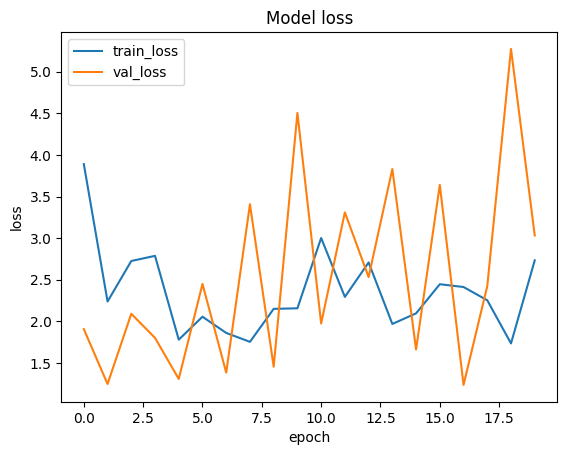

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

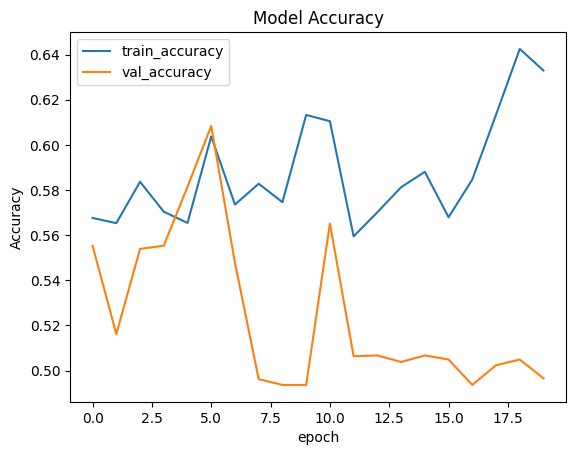

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = metrics)

In [ ]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
  2/689 [..............................] - ETA: 13:59 - loss: 0.9251 - tp: 20.0000 - fp: 12.0000 - tn: 19.0000 - fn: 13.0000 - accuracy: 0.6094 - precision: 0.6250 - recall: 0.6061 - auc: 0.5249

KeyboardInterrupt: ignored

###Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 28s 5ms/step - loss: 0.3756 - tp: 1292.0000 - fp: 127.0000 - tn: 1271.0000 - fn: 67.0000 - accuracy: 0.9296 - precision: 0.9105 - recall: 0.9507 - auc: 0.9665


[0.37560024857521057,
 1292.0,
 127.0,
 1271.0,
 67.0,
 0.9296336770057678,
 0.9105003476142883,
 0.9506990313529968,
 0.9664850234985352]

###Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [ ]:
print(labels)
labels = np.array([i[0] for i in labels])
print(labels)

[array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), arr

In [ ]:
predicted = model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 [==============================] - 2s 16ms/step
[9.9896526e-01 1.5603980e-02 9.9921834e-01 ... 9.9931681e-01 1.9930454e-03
 5.1060069e-04]


[[1316   80]
 [ 161 1200]]


Text(0.5, 58.7222222222222, 'Predicted')

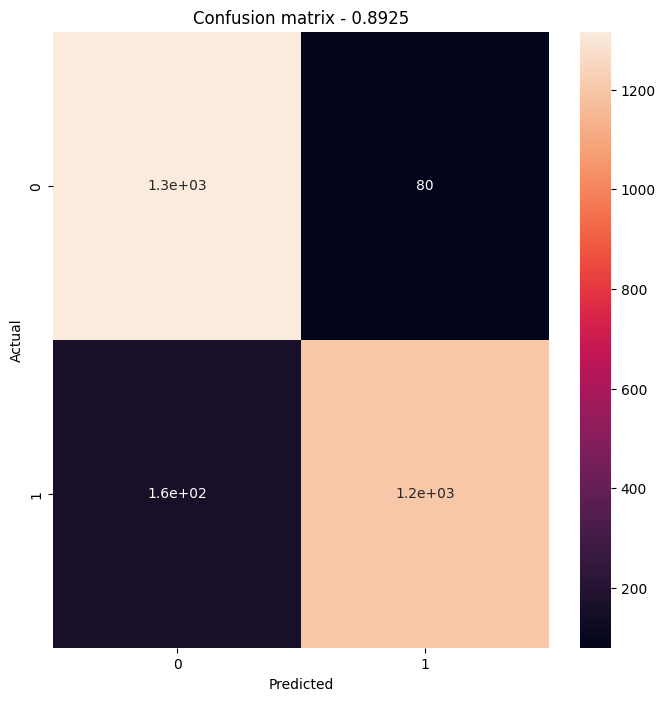

In [ ]:
threshold = 0.8925
cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

###ROC PLots


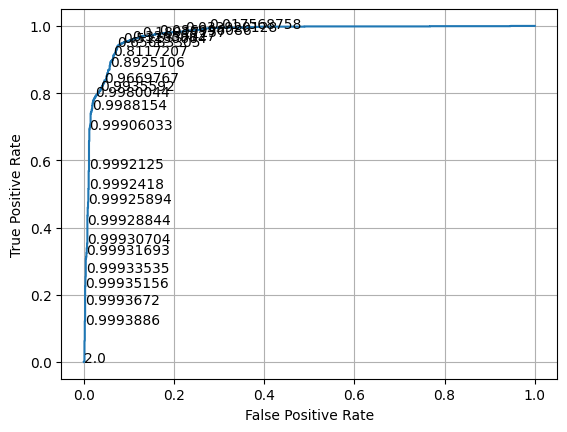

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
#print(len(fp), len(tp), len(thresholds))
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'P'

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 19ms/step


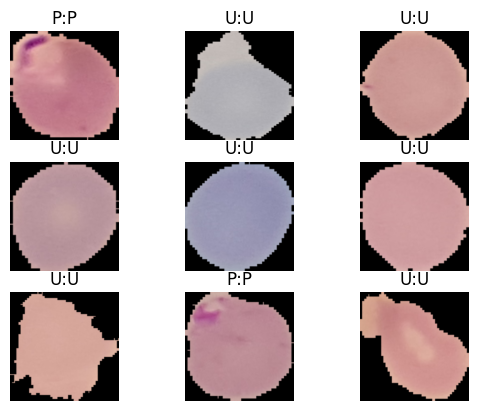

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":"+ str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

###SAve to and loading from google drive

In [ ]:
drive.mount('/content/drive/')


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/